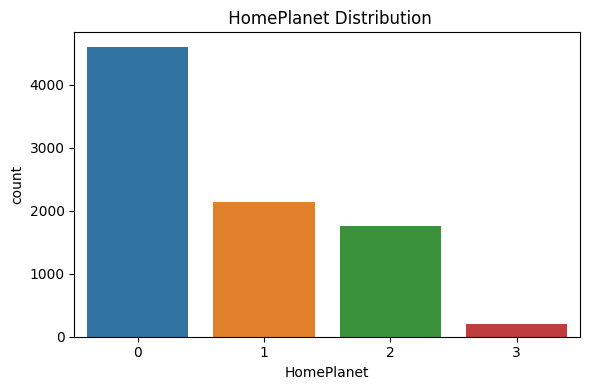

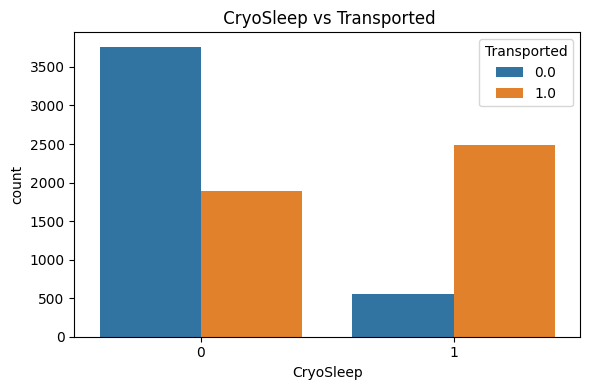

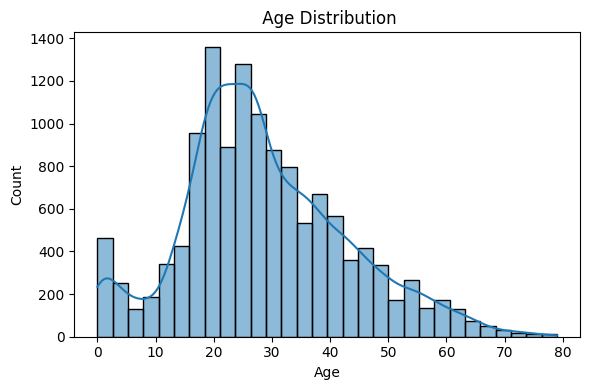

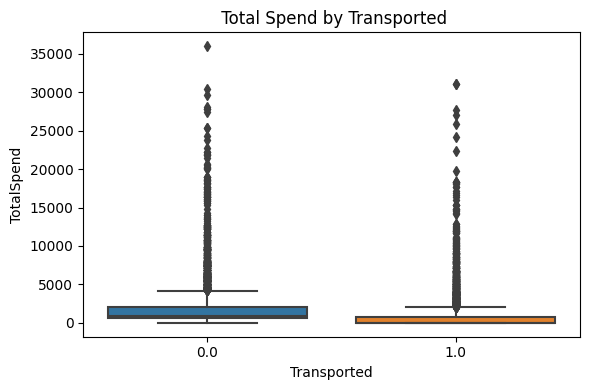

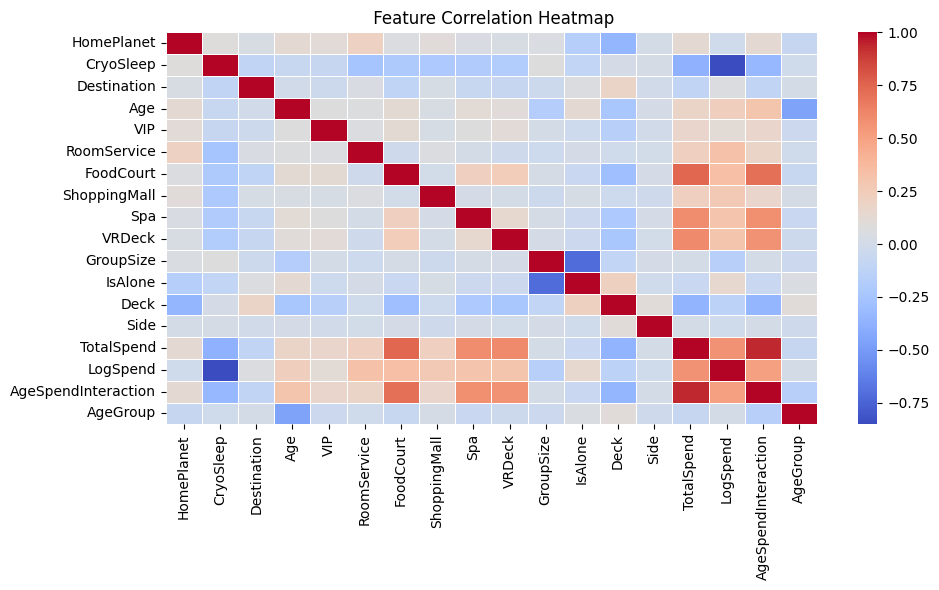

[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2168
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2168
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 18
[LightGBM] [Info] [binary:

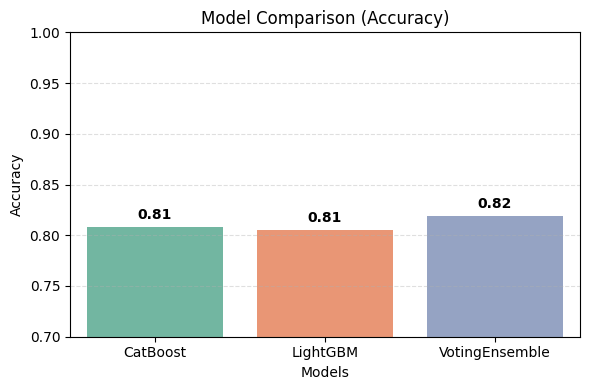

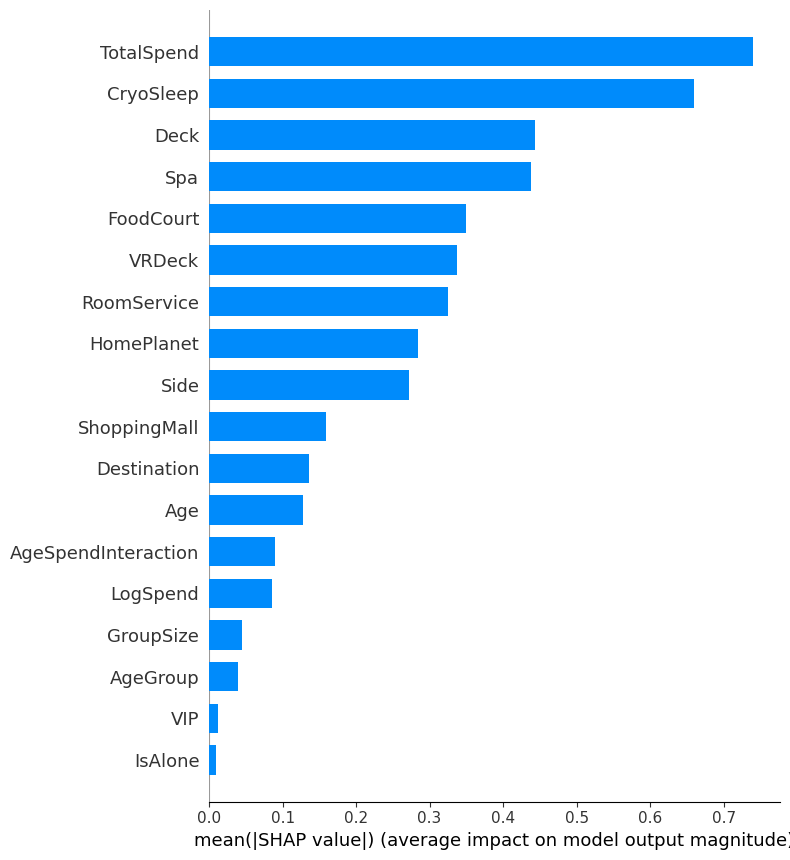

Submission saved: spaceship_submission.csv


,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


In [41]:
# INSTALL
!pip install catboost lightgbm shap -q

# IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier

# LOAD DATA
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submission = pd.read_csv("sample_submission.csv")

test["Transported"] = np.nan
train["source"] = "train"
test["source"] = "test"
full = pd.concat([train, test], sort=False)

# FEATURE ENGINEERING
full["Group"] = full["PassengerId"].apply(lambda x: x.split('_')[0])
full["GroupSize"] = full.groupby("Group")["Group"].transform("count")
full["IsAlone"] = (full["GroupSize"] == 1).astype(int)
full["Cabin"] = full["Cabin"].fillna("Z/0/Z")
full[["Deck", "CabinNum", "Side"]] = full["Cabin"].str.split("/", expand=True)
full["HomePlanet"] = full["HomePlanet"].fillna("Unknown")
full["Destination"] = full["Destination"].fillna("Unknown")
full["CryoSleep"] = full["CryoSleep"].fillna(False)
full["VIP"] = full["VIP"].fillna(False)
full["Age"] = full["Age"].fillna(full["Age"].median())
full["Name"] = full["Name"].fillna("Unknown")

spend_cols = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
for col in spend_cols:
    full[col] = full[col].fillna(0)
full["TotalSpend"] = full[spend_cols].sum(axis=1)
full["LogSpend"] = np.log1p(full["TotalSpend"])
full["AgeSpendInteraction"] = full["Age"] * full["TotalSpend"]
full["AgeGroup"] = pd.cut(full["Age"], bins=[0, 12, 18, 30, 50, 80],
                          labels=["Child", "Teen", "YoungAdult", "Adult", "Senior"])

cat_cols = ["HomePlanet", "Destination", "Deck", "Side", "AgeGroup"]
for col in cat_cols:
    full[col] = LabelEncoder().fit_transform(full[col].astype(str))
full["CryoSleep"] = full["CryoSleep"].astype(int)
full["VIP"] = full["VIP"].astype(int)

full.drop(columns=["PassengerId", "Name", "Cabin", "Group", "CabinNum", "source"], inplace=True)

# EDA PLOTS
def run_eda_plots(data):

    plt.figure(figsize=(6, 4))
    sns.countplot(data=data[~data["Transported"].isna()], x="HomePlanet")
    plt.title(" HomePlanet Distribution")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 4))
    sns.countplot(x="CryoSleep", hue="Transported", data=data[~data["Transported"].isna()])
    plt.title(" CryoSleep vs Transported")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 4))
    sns.histplot(data["Age"], bins=30, kde=True)
    plt.title(" Age Distribution")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 4))
    sns.boxplot(x="Transported", y="TotalSpend", data=data[~data["Transported"].isna()])
    plt.title(" Total Spend by Transported")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))
    corr = data.select_dtypes(include=["int64", "float64"]).corr()
    sns.heatmap(corr, annot=False, cmap="coolwarm", linewidths=0.5)
    plt.title(" Feature Correlation Heatmap")
    plt.tight_layout()
    plt.show()

run_eda_plots(full)

# SPLIT DATA
train_cleaned = full[~full["Transported"].isna()]
test_cleaned = full[full["Transported"].isna()].drop(columns=["Transported"])
X = train_cleaned.drop(columns=["Transported"])
y = train_cleaned["Transported"].astype(int)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
test_scaled = scaler.transform(test_cleaned)

# MODELS
cat = CatBoostClassifier(verbose=0, random_seed=42)
lgb = LGBMClassifier(random_state=42)
voting = VotingClassifier(estimators=[('cat', cat), ('lgb', lgb)], voting='soft')

cat.fit(X_train_scaled, y_train)
lgb.fit(X_train_scaled, y_train)
voting.fit(X_train_scaled, y_train)

# EVALUATION FUNCTION
def evaluate_model(model, X_val, y_val, name="Model"):
    preds = model.predict(X_val)
    acc = accuracy_score(y_val, preds)
    print(f"\n{name} Accuracy: {acc:.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_val, preds))
    print("Classification Report:")
    print(classification_report(y_val, preds))
    return acc

# EVALUATE MODELS
acc_cat = evaluate_model(cat, X_val_scaled, y_val, "CatBoost")
acc_lgb = evaluate_model(lgb, X_val_scaled, y_val, "LightGBM")
acc_voting = evaluate_model(voting, X_val_scaled, y_val, "VotingEnsemble")

# MODEL COMPARISON PLOT
model_names = ["CatBoost", "LightGBM", "VotingEnsemble"]
accuracies = [acc_cat, acc_lgb, acc_voting]

plt.figure(figsize=(6, 4))
sns.barplot(x=model_names, y=accuracies, palette="Set2")

for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.005, f"{acc:.2f}", ha='center', va='bottom',
             fontsize=10, fontweight='bold', color='black')

plt.title("Model Comparison (Accuracy)")
plt.ylim(0.7, 1.0)
plt.ylabel("Accuracy")
plt.xlabel("Models")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# SHAP (LightGBM)
explainer = shap.TreeExplainer(lgb)
shap_values = explainer.shap_values(X_val_scaled[:100])
shap.summary_plot(shap_values, X_val.iloc[:100], plot_type="bar")

# FINAL SUBMISSION
submission["Transported"] = voting.predict(test_scaled).astype(bool)
submission.to_csv("spaceship_submission.csv", index=False)
print("Submission saved: spaceship_submission.csv")
submission.head()